# Getting Started

This is a mini-tutorial on getting started with `edges_estimate`. It aims to cover what you need to know to build and run simple EDGES models over data, view parts of the model, read in the output MCMC chains, and make some plots.

Since `edges_estimate` is a simple extension to the underlying Bayesian framework `yabf`, you'll also learn a bit of how to use that library (no prior familiarity with it is assumed). Nevertheless, more details of `yabf` can be learned by reading [its documentation](https://yabf.readthedocs.org).

## Setup

First we'll import the primary namespaces in `edges_estimate`:

In [27]:
import edges_estimate as ee
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

In this tutorial we will exclusively use the low-band data from the Nature paper (Bowman et al. 2018). 
Note that this analysis was _not_ the analysis pipeline performed in that paper. Let's read in that publicly available data. Here, for simplicity, we have already converted the data into `.npy` format, which will be helpful later on:

In [2]:
freqs = np.load("edges_nature_data_freqs_full.npy")
temps = np.load("edges_nature_data_tsky_full.npy")

## Building a Model

There are two main ways to use `edges_estimate` (or indeed, `yabf`). One is via the command-line, using `YAML` configuration files. The other is directly in a python script. In this tutorial we'll show primarily the latter, though we will try to give an idea of the former as well.

`yabf` provides a way to create arbitrary hierarchically-nested Bayesian models from some simple building blocks. 
We may use these fundamental building blocks at times, but `edges_estimate` provides ready-made solutions for fitting EDGES data (as you may expect), and here we will mostly use these.

The general structure of a `yabf` model is as follows. The outermost structure is called a `LikelihoodContainer`, and this is a simple container that holds _independent_ likelihoods (that is, independent in the sense that their log-posterior values may simply be added to generate a total posterior). They are _not_ necessarily independent in terms of the parameters they use -- a single parameter may affect any number of likelihoods in the container.

As already mentioned, the second layer of the structure is a number of `Likelihood`s. Each of these has specific methods to calculate priors and likelihoods. In fact, if a single likelihood is used, that likelihood can form the top layer, and no `LikelihoodContainer` is required. Each likelihood can be given a number of `Parameter`s and also an arbitrary number of what we call `Component`s (we'll talk about these soon). The `Likelihood` uses the `Parameter` data to calculate its priors and internally passes them around to determine its likelihood. Note that in `yabf`, there is a distinction between active and passive parameters. Each `Likelihood`, as defined in code, has a number of predefined `Parameter`s, which define some attributes of the parameter. Nevertheless, in any given fit, only a subset of these need to be actually varied, and these become "active". What's more, active parameters defined at runtime may correspond to _more_ than one `Parameter` in _more_ than one likelihood, and this correspondence may occur through an arbitrary transformation. We will get into that later. The beauty of `yabf` is that the model is constructed in such a way that even if there are multiple connected parameters in the likelihoods, you can isolate each likelihood and it still works as expected.

The third layer of the structure are the `Component`s. These also can be defined with `Parameter`s, much like `Likelihood`s, but they do not calculate either priors or likelihoods. Instead, they are re-useable components that calculate parts of the forward-model. They are not necessary (the likelihood could contain a method to calculate the forward model itself), but they are useful because of this re-useability. Furthermore, `Component`s can contain `Component`s to an arbitrary hierarchical level. Again, while the parent `Likelihood` controls how each of the interdependent children `Component`s behave, it is quite possible to isolate a `Component` at an arbitrary level, and generate its own contribution just as you would expect. This makes interactive testing much simpler.

So how does this all work together? The general workflow can be stated as containing two parts: setup and evaluation. At setup (which happens at the creation of a `LikelihoodContainer` or `Likelihood` instance) the following happens:
1. The `Likelihood` determines an ordered list of its `Component`s, and each of them do the same for their subcomponents. A full ordered list of all subcomponents (down to arbitrary level) is available at each level. 
2. The `Parameter`s given by the user at all levels of the heirarchy are gathered and compared -- those with the same name are assumed to be the same parameter (i.e. a single number will be passed to both), even if their class-definition name is not the same. 
3. A mapping is built from input parameter name to a full hierarchical dictionary of parameters, so that any function call to which parameters are given can be propagated.

At evaluation, the following happens:
1. Given a `Likelihood` instance called `lk`, we _call_ the instance, and in the simplest case, we pass it a map of input parameters. These parameters correspond to the _active_ parameter names. Not all active parameters must be given (though they will in an MCMC run) -- those that are not will receive default values (which can also be defined/overwritten at instantiation).
2. These parameters are deployed down the graph using the parameter mapping.
3. The tree of `Component`s is evaluated, from bottom-up. Each component has a single method which calculates an arbitrary dataset and adds it to an internal `ctx` dictionary under a key specified by the `Component` definition. parent `Component`s then have access to any of the data generated by their children, and may modify it or add to it.
4. Finally, the `Likelihood` receives the full `ctx` dictionary (along with its active parameters), and performs three steps:
    a. It performs a `reduce` step, in which it reduces that data into the most dense form possible before comparison with data
    b. It calculates the `posterior` by comparing the output of the reduction (termed the `model`) with data.
    c. It calculates priors for all active parameters.

One final layer remains, and this is an outer layer above even the `LikelihoodContainer`: it is the `Sampler`. This controls sampling in the MCMC, and it has methods for advancing the sampling, storing chain data etc. We will look at this a bit later.

This is all a bit abstract, but is useful to get an overall idea of what's happening. Let's create a specific model for the EDGES data. We will do this bit-by-bit to show that each part is self-contained, but it could also be done in a single call.

### Our First Component (Foregrounds)

Our first component will be foregrounds, which exist in the `foregrounds` module. There are a number of foreground models currently available, and new ones are easy to write based on those that are there already:

In [3]:
ee.foregrounds.Component._plugins

{'Foreground': edges_estimate.foregrounds.Foreground,
 '_PhysicalBase': edges_estimate.foregrounds._PhysicalBase,
 'PhysicalHills': edges_estimate.foregrounds.PhysicalHills,
 'PhysicalSmallIonDepth': edges_estimate.foregrounds.PhysicalSmallIonDepth,
 'PhysicalLin': edges_estimate.foregrounds.PhysicalLin,
 'LinLog': edges_estimate.foregrounds.LinLog,
 'Sinusoid': edges_estimate.foregrounds.Sinusoid,
 'DampedSinusoid': edges_estimate.foregrounds.DampedSinusoid,
 'LinPoly': edges_estimate.foregrounds.LinPoly,
 'Bias': edges_estimate.foregrounds.Bias,
 'AbsorptionProfile': edges_estimate.eor_models.AbsorptionProfile}

Let's use a `LinLog` model:

In [4]:
linlog = ee.foregrounds.LinLog(
    name = 'foregrounds',
    params = {"p0": {}, "p1": {}, "p2": {}, "p3": {}},
    freqs = freqs,
    poly_order = 4
)

Note here that we give a name to the component. If we had not, its name would be equal to the class name. 
We are also specifying four _active_ parameters, `p0...p3`. Each of them is defined as a dictionary controlling its behaviour, however we leave each blank here, as we are happy with the default behaviour of each parameter, defined as part of the class. 
The arguments `freqs` and `poly_order` are extra arguments specific to the `Foreground` subclass of `Component`. 
In this case `poly_order` is able to dynamically specify the number of polynomial terms, creating default `Parameter`s for them. Note that we could have specified `poly_order=8` and kept the same definition of `params = `. This would mean that `p4...p7` would exist, but not be _active_ (i.e. not constrained in an MCMC). In this case, the default values of those parameters is zero, so this would have no effect.

Now, we can use this component right off the bat, with putting it into any kind of `Likelihood`:

In [5]:
linlog.fiducial_params

{'p0': 1750.0, 'beta': -2.5, 'p1': 0.0, 'p2': 0.0, 'p3': 0.0}

Notice that `beta` (the spectral index) is a parameter of the component, but we did not pass it above. That means it is not active:

In [6]:
linlog.active_params_dct.keys()

odict_keys(['p0', 'p1', 'p2', 'p3'])

The full list of base parameters (defined in the class itself, not at runtime, i.e. not _active_) can be seen with

In [7]:
linlog.base_parameters

(Parameter(name='beta', fiducial=-2.5, min=-5.0, max=0.0, latex='\\beta'),
 Parameter(name='p0', fiducial=1750.0, min=-inf, max=inf, latex='p_0'),
 Parameter(name='p1', fiducial=0.0, min=-inf, max=inf, latex='p_1'),
 Parameter(name='p2', fiducial=0.0, min=-inf, max=inf, latex='p_2'),
 Parameter(name='p3', fiducial=0.0, min=-inf, max=inf, latex='p_3'))

Notice that each is an instance of the `Parameter` class, and defines a number of helpful attributes. These are attributes that can be overwritten by the dictionaries passed when creating the instance. In fact, here is the full list of attributes that can be specified:

In [8]:
linlog.active_params[0]

Param(name='p0', fiducial=1750.0, min=-inf, max=inf, latex='p_0', ref=None, prior=None, determines=('p0',), _parameter_mappings=(None,))

Notice that this is a `Param` instance (subtly different than `Parameter`), which indicates an active parameter. Notice that the first 5 attributes are inherited directly from its `Parameter`. The remaining attributes _only_ make sense if it is active: `ref` is a function which randomly chooses a value from a "reference" distribution (by default, this is the same as its prior). `prior` is a `scipy.stats` distribution (default uniform) that is able to draw random samples and evaluate its pdf. `determines` provides a mapping from the active param `name` to the name of a `base_parameter`. By default, its just the same as the name, but it can be changed (and sometimes this is necessary, as we'll see). Finally, `parameter_mappings` provides a set of functions to convert the given parameter to its final form as a `Parameter`.

Let's see what would have happened had we used some of these options:

In [9]:
linlog2 = ee.foregrounds.LinLog(
    params = {"p0_for_low": {"min": 0, "latex": "p_0", "determines":("p0", )}},
    freqs = freqs,
    poly_order = 4
)

In [10]:
linlog2.active_params

(Param(name='p0_for_low', fiducial=1750.0, min=0.0, max=inf, latex='p_0', ref=None, prior=None, determines=('p0',), _parameter_mappings=(None,)),)

In [11]:
linlog2.name

'LinLog'

Now let's calculate some foregrounds using our linlog model:

In [12]:
linlog_ctx = linlog()

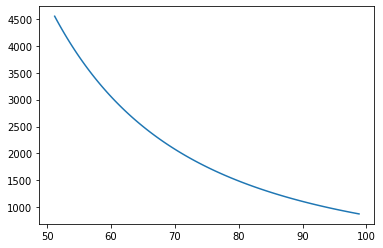

In [13]:
plt.plot(linlog.freqs, linlog_ctx['foregrounds_spectrum']);

Now, we could have passed other parameters. You can pass active parameters directly:

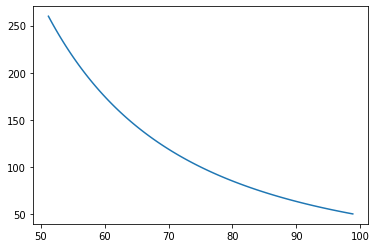

In [14]:
plt.plot(linlog.freqs, linlog(params={"p0":100})['foregrounds_spectrum']);

Note that if the name of an active parameter is changed, you can pass it as the new name:

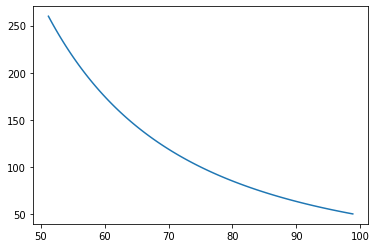

In [15]:
plt.plot(linlog2.freqs, linlog2(params={"p0_for_low":100})['LinLog_spectrum']);

(note here that the name of the output data key has changed, because in this case it is automatically determined by the component's `name`.) Alternatively, you can use the true `Parameter` name:

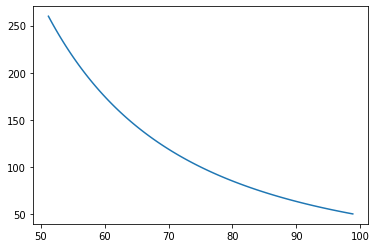

In [16]:
plt.plot(linlog2.freqs, linlog2(params={"p0":100})['LinLog_spectrum']);

If there are active parameters, you can also pass a simple list of values, which correspond exactly to the ordered tuple of child active parameters:

odict_keys(['p0', 'p1', 'p2', 'p3'])


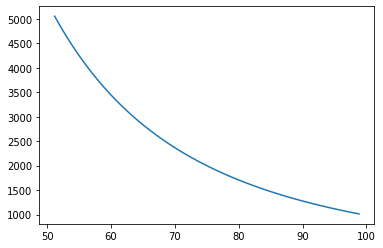

In [17]:
print(linlog.child_active_param_dct.keys())
plt.plot(linlog.freqs, linlog(params=[2000, 100, -100, 50])['foregrounds_spectrum']);

Note that when using a list like this, the list _must_ be the same length as the `child_active_params` tuple.

Finally, we can also pass explicit values for non-activate parameters:

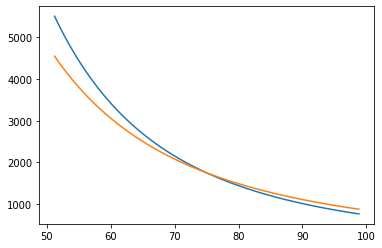

In [18]:
plt.plot(linlog.freqs, linlog(params={"beta": -3.0})['foregrounds_spectrum']);
plt.plot(linlog.freqs, linlog()['foregrounds_spectrum']);


### Absorption Component

With all that in hand, let's create an absorption-trough component:

In [21]:
eor = ee.eor_models.AbsorptionProfile(
    params = ('A', "nu0", 'tau', 'w'),
    freqs = freqs
)

Note that we have used a tuple of strings as the input params here: this is equivalent to the dictionary of empty dicts.

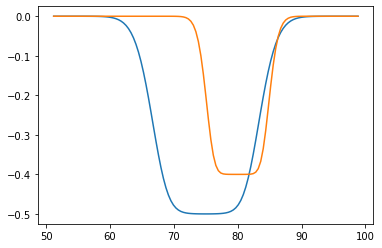

In [25]:
plt.plot(eor.freqs, eor()['eor_spectrum']);
plt.plot(eor.freqs, eor(params=[0.4, 80, 10, 10])['eor_spectrum']);

### Making a Likelihood

The primary kind of likelihood we will want to use for EDGES analysis is a $\Chi^2$ likelihood. In our case, we use what we call a `MultiComponentChi2`: basically, it takes a number of components that calculate independent spectra, adds them together, and then compares to data.

In [28]:
lk = ee.likelihoods.MultiComponentChi2(
    name='lk',
    params={"sigma": {"prior": stats.norm(0.2, 0.05)}},
    components=(linlog, eor)
)

Note that we here passed an explicit prior for $\sigma$, which encodes the amount of thermal noise in the data. 